In [91]:

import os
import sys
import pickle
import warnings
import time
import logging
import glob

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from iminuit import Minuit
from matplotlib import ticker
from matplotlib.legend import Legend

from statsmodels.tsa.stattools import acf 
from statsmodels.graphics.tsaplots import plot_acf


from utils import *
from AnalyseDefects import AnalyseDefects

plt.style.use('sg_article')

In [80]:
def gen_analysis_dict(LL, mode):

    dshort = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05', \
              suffix = "short", priority = -1, LX = LL, Nframes = 181)
    dlong = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_long', \
                suffix = "long", priority = 1, LX = LL, Nframes = 400)
    priority_vl = 2 if LL == 512 else 3
    dvery_long = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long',\
                    suffix = "very_long", priority = priority_vl, LX = LL, Nframes = 1500)
    dvery_long2 = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long_v2',\
                    suffix = "very_long2", priority = 3 if priority_vl == 2 else 2, LX = LL, Nframes = 1500)

    if mode == 'all':
        if LL == 2048:
            defect_list = [dshort, dlong]
        else:
            defect_list = [dshort, dlong, dvery_long, dvery_long2] if LL in [256, 512] else [dshort, dlong, dvery_long]
    else:
        defect_list = [dshort]
    
    return defect_list

LL = 1024
output_path = f'data\\nematic_analysis{LL}_LL0.05'
mode = 'all' # 'all' or 'short'

defect_list = gen_analysis_dict(LL, mode)

ad = AnalyseDefects(defect_list, output_path=output_path)

extract = False
analyze = False
merge = False

In [253]:
N = -1
def_arr = ad.get_arrays_full(Ndataset=N)[0]
kbins, sfac = ad.get_sfac_pcf(Ndataset=N, time_av=False)[:2]
act_list = ad.act_list[N]
conv_list = ad.conv_list[N] 
def_arr_series = pd.DataFrame(def_arr[:,N,0], columns=['defect_density'])
#pd.plotting.lag_plot(def_arr_series, lag=40);

In [252]:
sfac.shape

(1500, 50, 9, 2)

In [87]:
# extracting only the temperature values
values = pd.DataFrame(def_arr_series.values)
 
# using shift function to shift the values.
dataframe = pd.concat([values.shift(3), values.shift(2),
                       values.shift(1), values], axis=1)
# naming the columns
dataframe.columns = ['t', 't+1', 't+2', 't+3']
 
# using corr() function to compute the correlation
result = dataframe.corr()
 
print(result)

            t       t+1       t+2       t+3
t    1.000000  0.991623  0.984456  0.977774
t+1  0.991623  1.000000  0.991616  0.984464
t+2  0.984456  0.991616  1.000000  0.991613
t+3  0.977774  0.984464  0.991613  1.000000


In [44]:
from statsmodels.tsa.stattools import acf 
from statsmodels.graphics.tsaplots import plot_acf
act_idx = -2
acf_arr, confint, qstat, pvals = acf(def_arr[conv_list[act_idx]:,act_idx,0], nlags=500, qstat=True, alpha=0.05)

In [145]:
def calc_acf_for_arr(arr, conv_idx = 0, nlags = 0, alpha = 0.05):
    """
    takes def arr with shape (Nframes, Nexp) and calculates the acf for each act and each exp 
    nlags = 0: calculate all lags
    """
    Nframes, Nexp = arr.shape
    nlags = Nframes - conv_idx if nlags == 0 else min(Nframes - conv_idx, nlags)

    acf_arr = np.nan * np.zeros((Nframes + 1, Nexp))
    confint_arr = np.nan * np.zeros((Nframes + 1, 2, Nexp))

    for i in range(Nexp):
        acf_res, confint = acf(arr[conv_idx:,i], nlags = nlags, alpha = alpha)
        acf_arr[-(nlags + 1):, i] = acf_res
        confint_arr[-(nlags + 1):, :, i] = confint

    return acf_arr, confint_arr



In [196]:
def estimate_effective_sample_size(acf_vals, acf_err_vals = None, confint_vals = None, max_lag=None, threshold=0.1, use_abs_sum=False):
    """ acf_vals must not be non ie. start from steady state.
    if max_lag is None, the first lag where the confidence interval is below threshold is used.

    Returns the effective sample size N_eff, tau
    """
    N = acf_vals.shape[0]

    if max_lag is None:
        if acf_err_vals is None:
            max_lag = np.where(confint_vals[:,0] < threshold)[0][0]
        else:
            max_lag = np.where(acf_vals[:max_lag] - acf_err_vals[:max_lag]  < threshold)[0][0]

    # Sum the autocorrelation values
    if use_abs_sum:
        tau = 1 + 2 * np.sum(np.abs(acf_vals[1:max_lag]))
    else:
        tau = 1 + 2 * np.sum(acf_vals[1:max_lag])
    
    # Effective sample size
    N_eff = N / tau
    return N_eff, tau

In [140]:
estimate_effective_sample_size(acf_avg, confint_avg, threshold=0.1,)

46


(7.1094536090193445, 49.37088267299571)

In [276]:
acf_sfac.shape, confint_sfac.shape

((401, 40), (401, 2, 40))

kbins = 0.01883018745274151, N_eff = 7.481349415780128, tau = 26.86681089591114
kbins = 0.025598641928842147, N_eff = 12.158367795001572, tau = 16.531824286696864
kbins = 0.032367096404942786, N_eff = 5.935437603819494, tau = 33.8643944080307
kbins = 0.039135550881043424, N_eff = 11.088346484336746, tau = 18.127139180213206
kbins = 0.045904005357144055, N_eff = 11.509110040382463, tau = 17.46442594559818
kbins = 0.052672459833244686, N_eff = 16.854773578940204, tau = 11.925404934015049
kbins = 0.059440914309345325, N_eff = 19.0229013667724, tau = 10.566211542845398
kbins = 0.06620936878544596, N_eff = 12.3689337727415, tau = 16.250390186659523
kbins = 0.07297782326154659, N_eff = 19.258169857585713, tau = 10.437128838638161
av of k, N_eff = 10.811529346982473, tau = 18.591264339128823


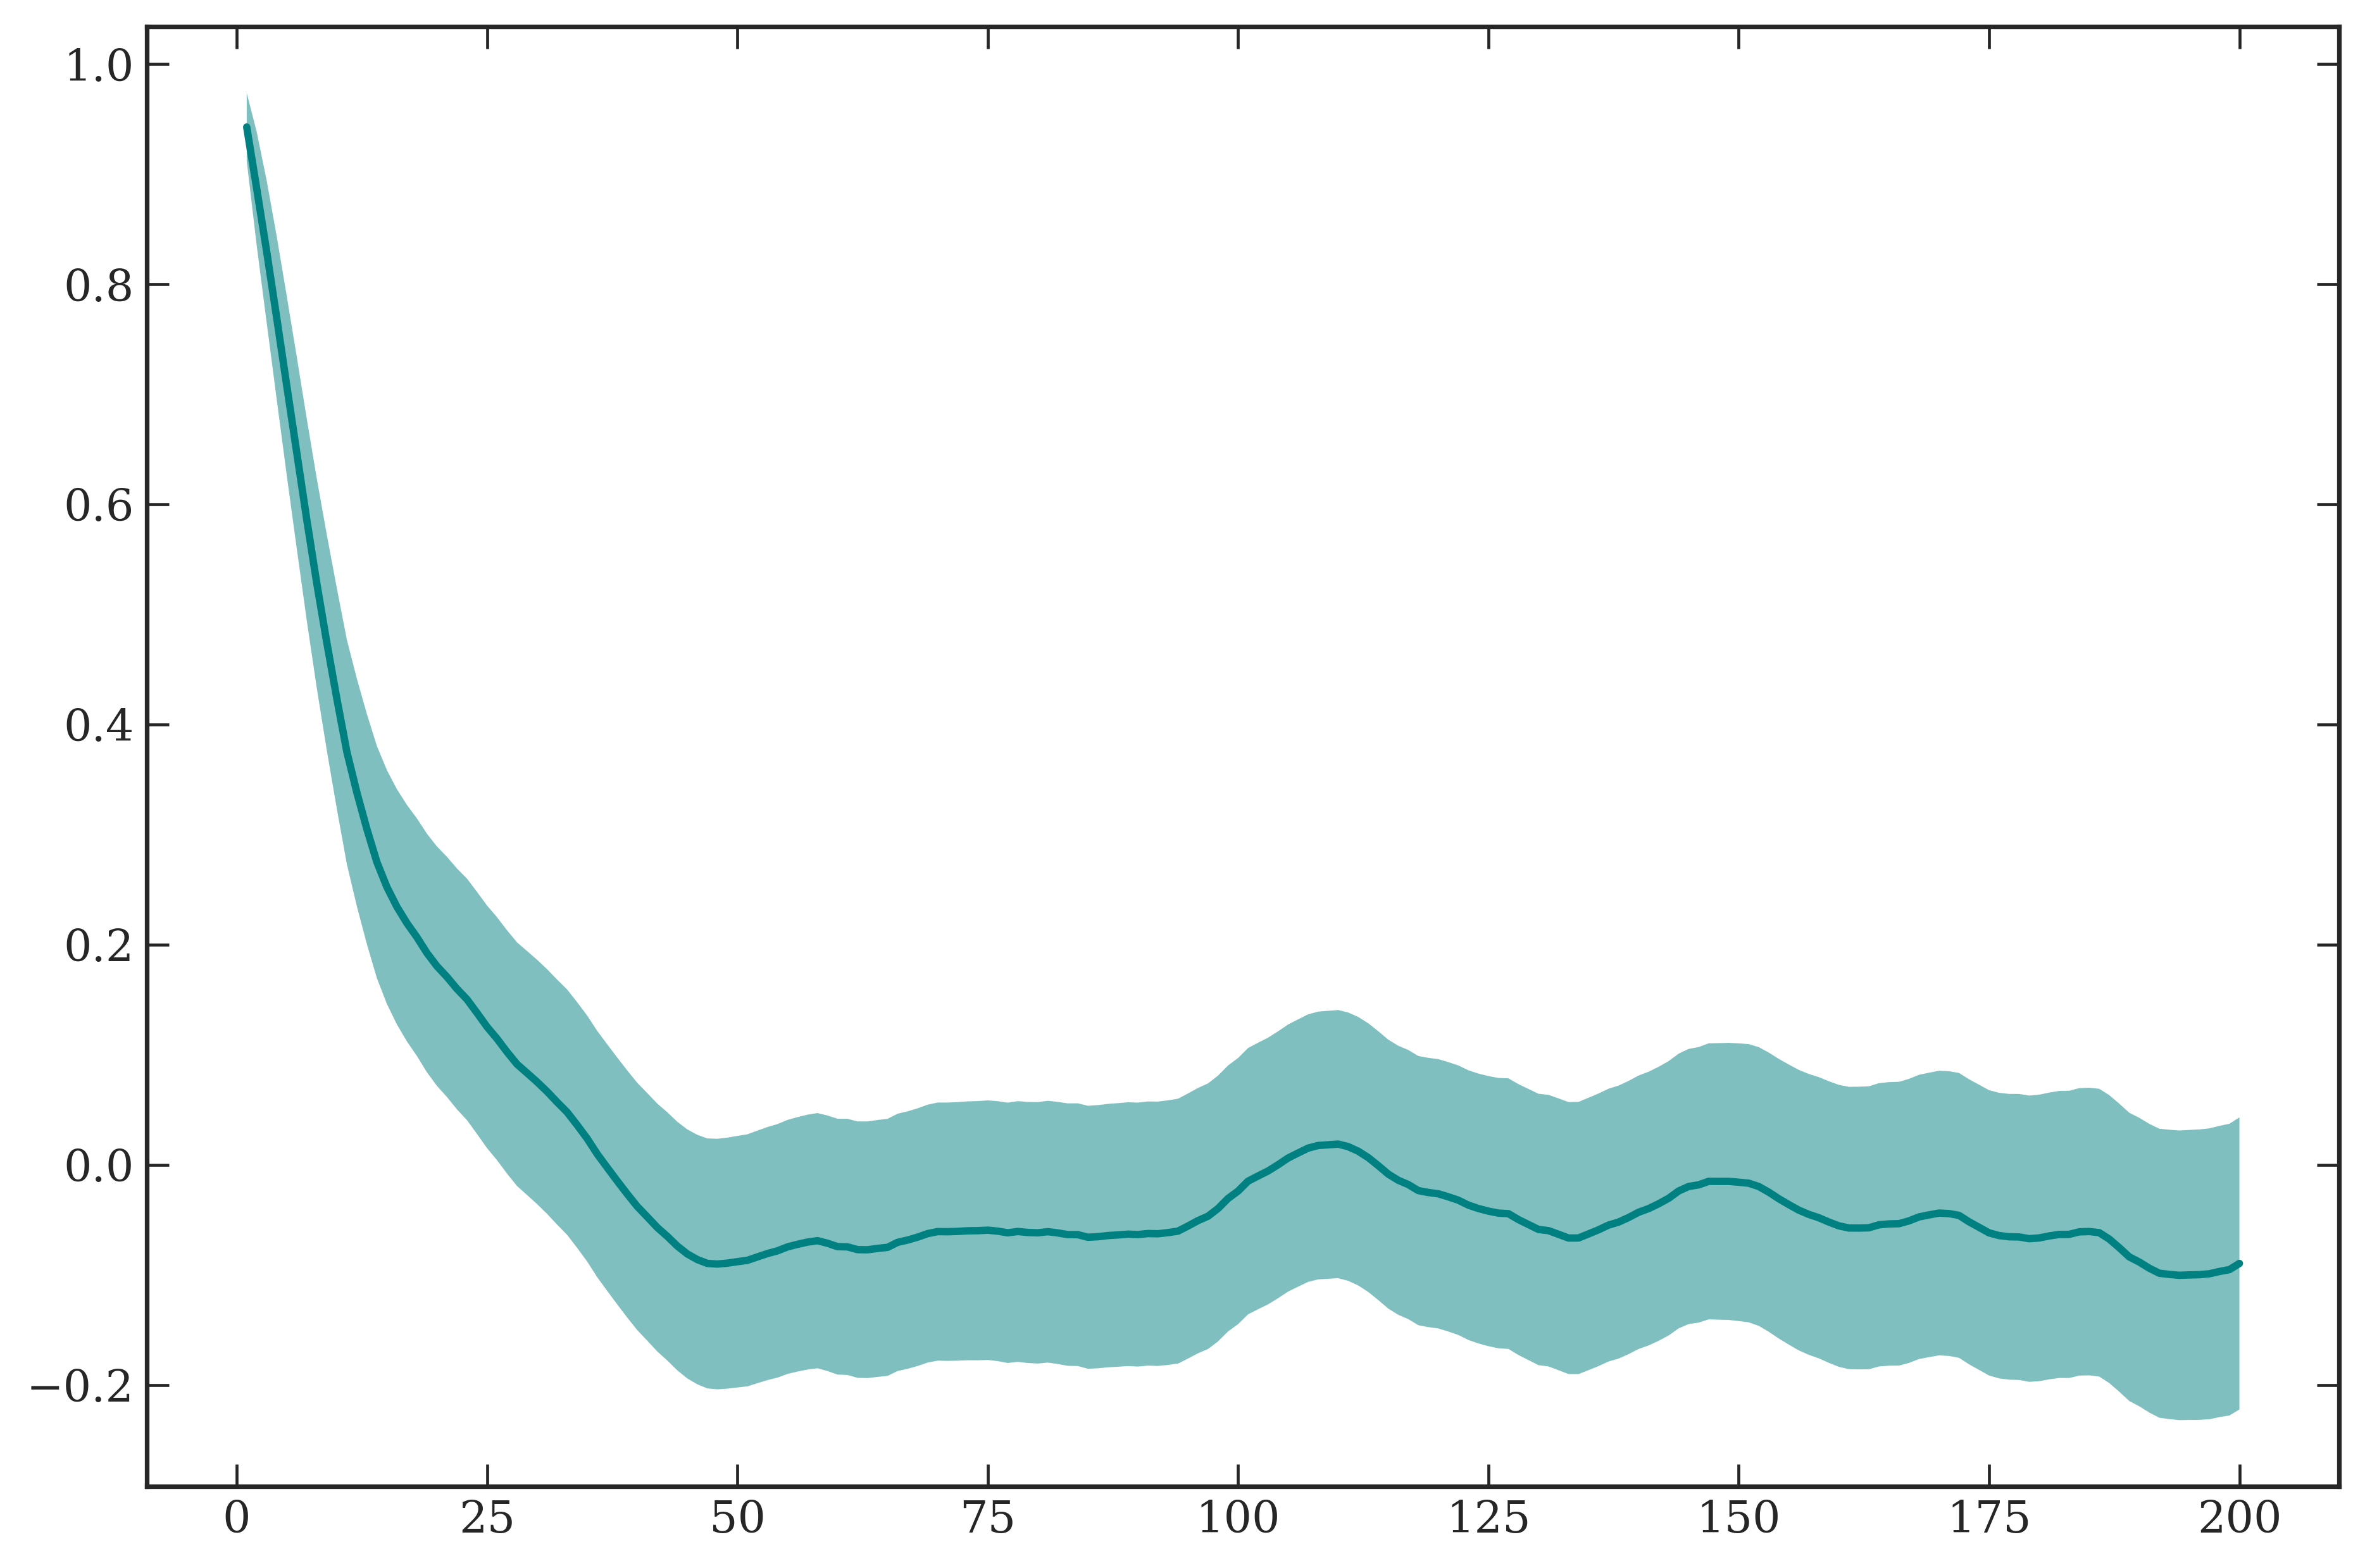

In [281]:
act = 0.022
act_idx = act_list.index(act)
alpha = 1 - 0.3413 * 2

conv_idx = conv_list[act_idx]
nf = def_arr.shape[0] - conv_idx
nlags = int(nf/2)

sfac_res = sfac[conv_idx:, :, act_idx, 0]
kmax_idx = 10

acf_sfac, confint_sfac = calc_acf_for_arr(sfac_res[:, :kmax_idx], nlags=nlags)
confint_arr_sym = np.abs(confint_sfac[:,1,:] - confint_sfac[:,0,:]) / 2

for i, k in enumerate(range(1, kmax_idx)):
    
    N_eff, tau = estimate_effective_sample_size(acf_sfac[-(nlags + 1):,i], acf_err_vals=None, confint_vals=confint_sfac[-(nlags + 1):, :, i], threshold=0.1,)
    print(f'kbins = {kbins[k]}, N_eff = {N_eff}, tau = {tau}')

acf_avg, confint_avg = calc_weighted_mean(acf_sfac[-(nlags + 1):,:], confint_arr_sym[-(nlags + 1):,:])
N_eff, tau = estimate_effective_sample_size(acf_avg, acf_err_vals=confint_avg, threshold=0.1,)
print(f'av of k, N_eff = {N_eff}, tau = {tau}')

plt.plot(acf_avg)
plt.fill_between(np.arange(acf_avg.shape[0]), acf_avg - confint_avg[:], acf_avg + confint_avg[:], alpha=0.5)

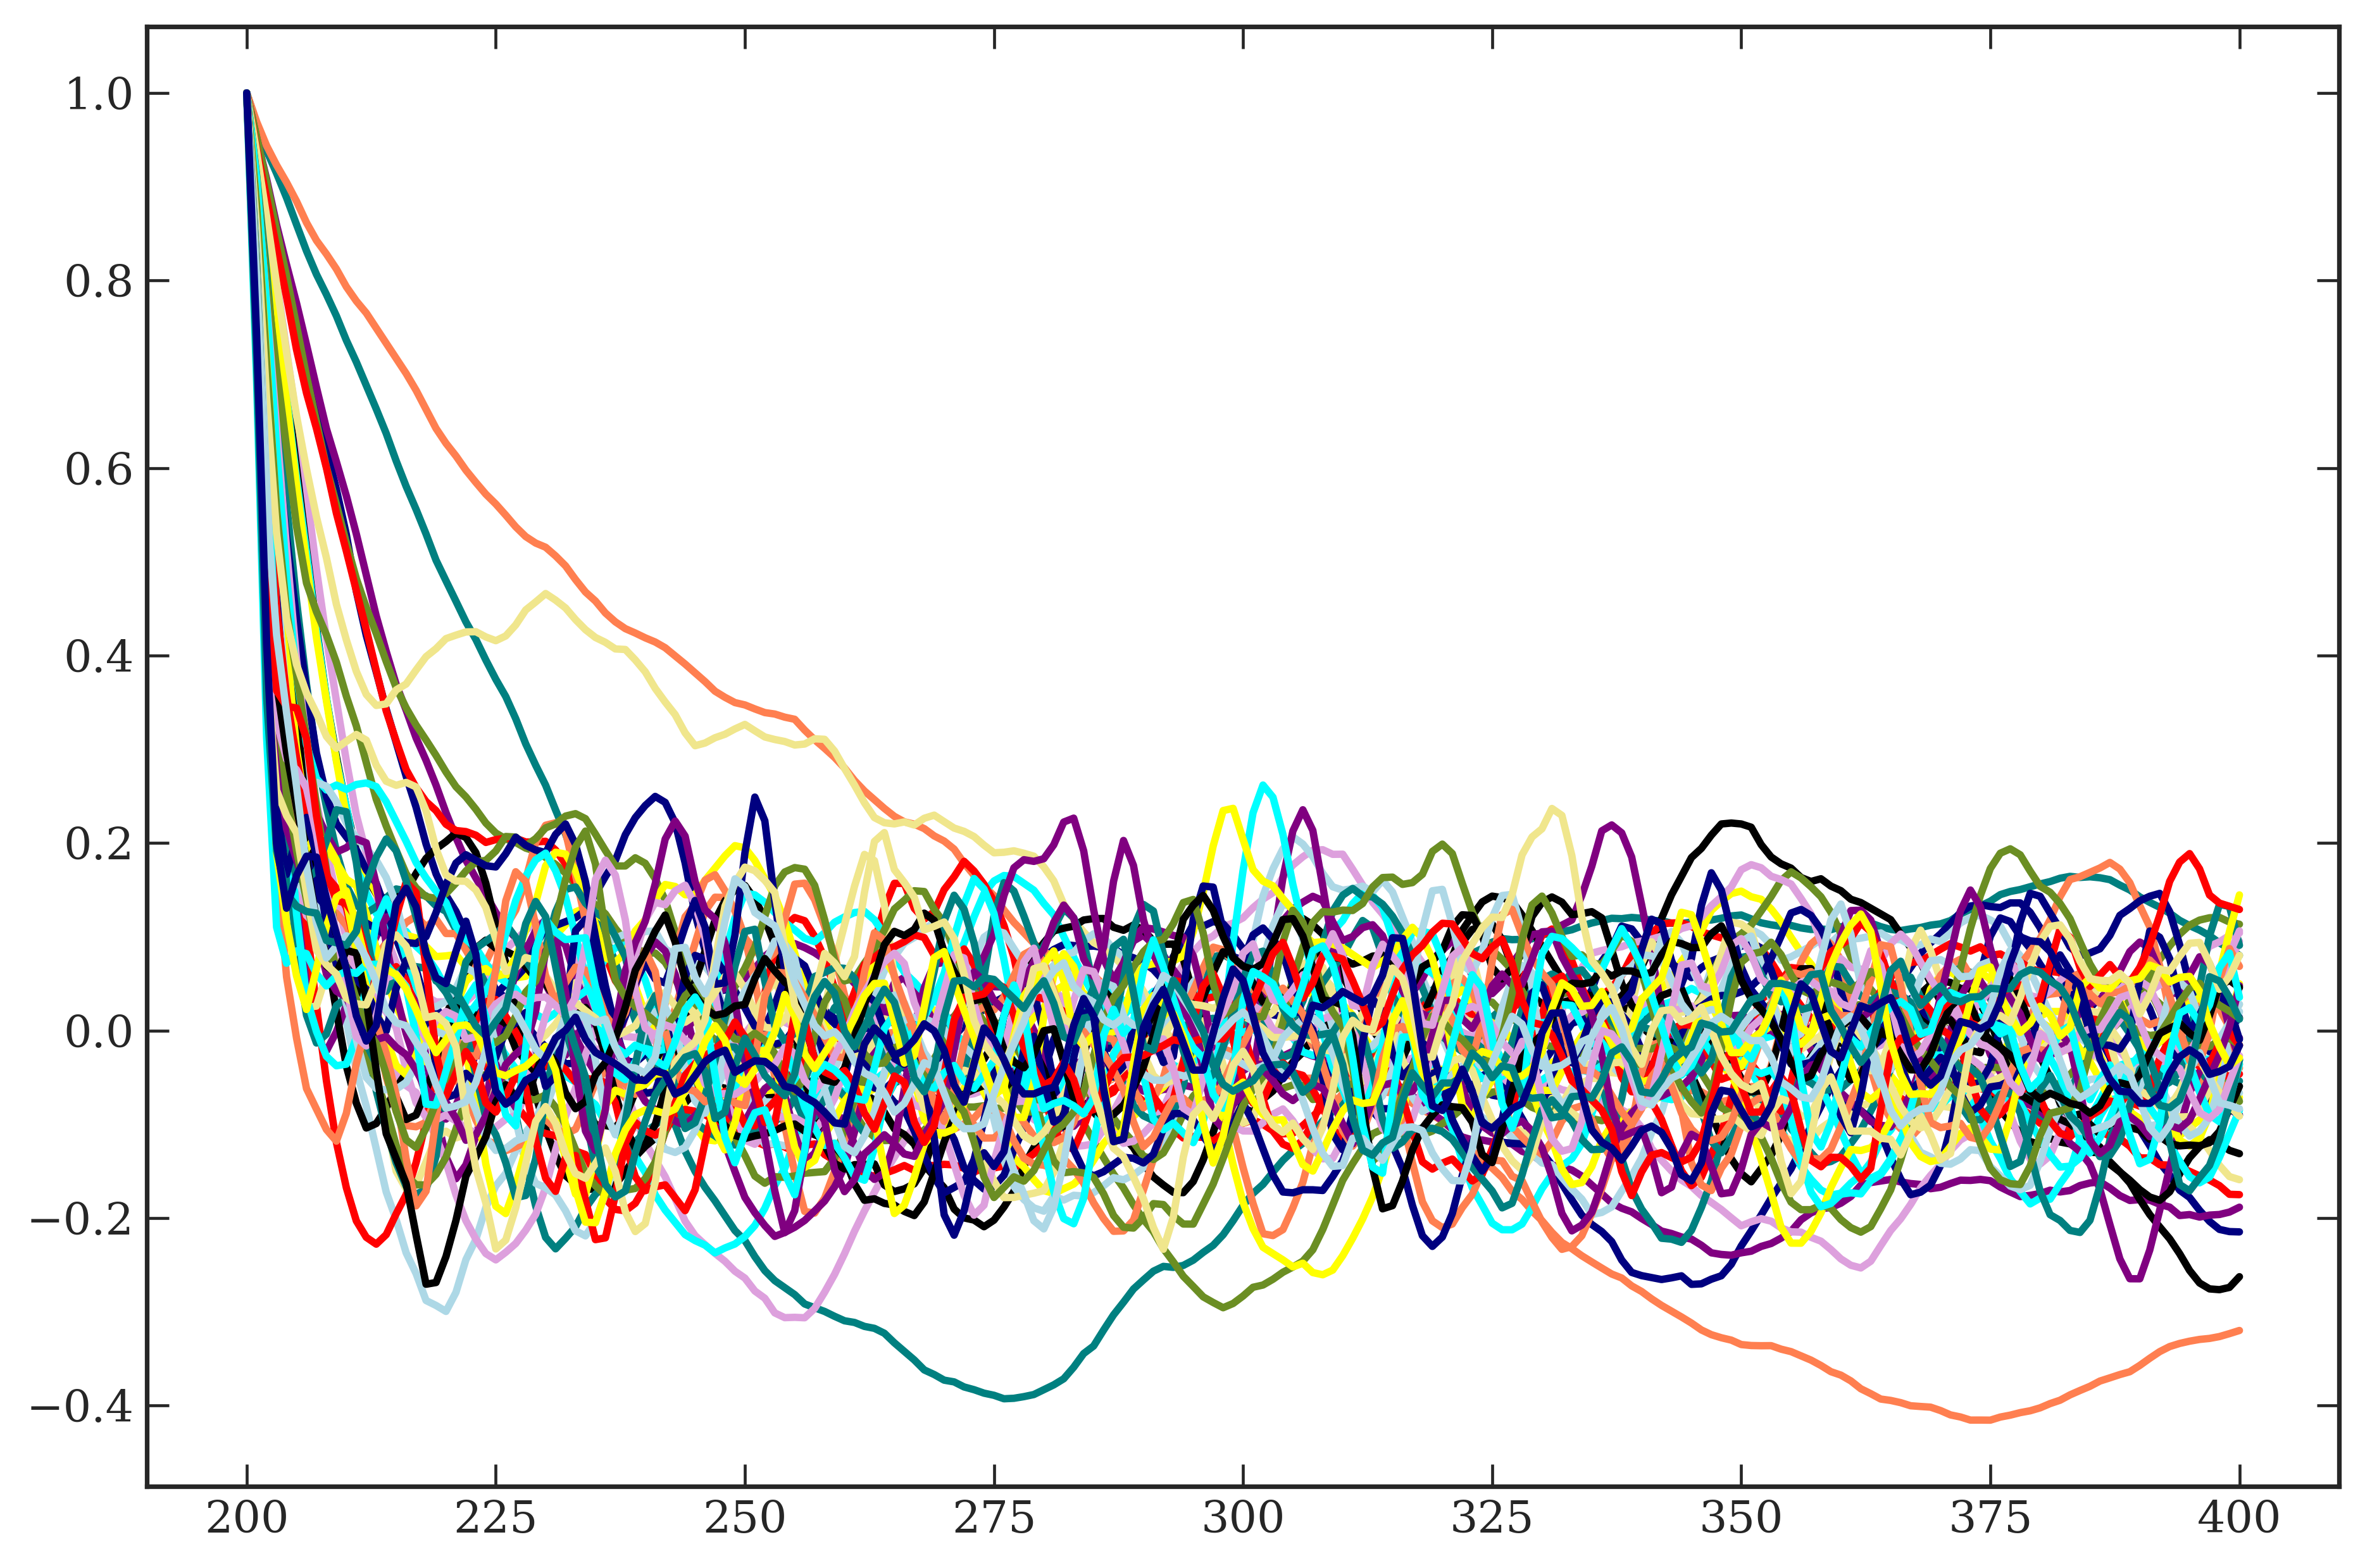

In [266]:
first_frame_confint_zero_avg = np.where(acf_avg - confint_avg < threshold)[0][0]
ax[acf_arr.shape[-1]].vlines(tau, -1, 1, color='black', linestyles='dashed', label=f'tau = {tau:.2f}')
ax[acf_arr.shape[-1]].plot(frames, acf_avg, '.', alpha=.3)  
ax[acf_arr.shape[-1]].fill_between(frames, acf_avg - confint_avg, acf_avg + confint_avg, alpha=.3)
ax[acf_arr.shape[-1]].vlines(first_frame_confint_zero_avg, -1, 1, color='red', linestyles='dashed', label='{:.2f}'.format(first_frame_confint_zero_avg))

ax[acf_arr.shape[-1]].hlines(0, 0, len(frames), color='black', linestyles='dashed') 
ax[acf_arr.shape[-1]].set_xlim(0, len(frames))
ax[acf_arr.shape[-1]].grid(True)
ax[acf_arr.shape[-1]].legend();


In [209]:
act = 0.0215
act_idx = act_list.index(act)
alpha = 1 - 0.3413 * 2

conv_idx = conv_list[act_idx]
nf = def_arr.shape[0] - conv_idx
nlags = 300

acf_arr, confint_arr = calc_acf_for_arr(def_arr[-nf:, act_idx, :], conv_idx = conv_idx, nlags = nlags, alpha = alpha)

#acf_arr, confint, qstat, pvals = acf(def_arr[conv_list[act_idx]:,act_idx,0], nlags=500, qstat=True, alpha=0.05)

In [ ]:
ad.plot_defects_per_exp(Ndataset=-1, act_idx_bounds=[act_idx, act_idx+2])

In [ ]:
fig, ax = ad.plot_defects_per_activity(Ndataset=-1, act_idx_bounds=[act_idx, act_idx+1])
ax[0].set_ylim(70, 100)
ax[0].grid(True)    
fig

In [ ]:
fig, ax = ad.plot_defects_per_activity(Ndataset=-1, act_idx_bounds=[act_idx-1, act_idx+1])
ax[0].set_ylim(500, 650)
ax[0].grid(True)    
fig

In [245]:
act_list

(0.0195, 0.02, 0.0205, 0.021, 0.0215, 0.022, 0.0225, 0.023, 0.0235, 0.024)

In [235]:
conv_list

array([   0,    0,  750,  800,  800,    0, 1100])

In [247]:
act = 0.023
act_idx = act_list.index(act)
alpha = 1 - 0.3413 * 2

conv_idx = conv_list[act_idx]
nf = def_arr.shape[0] - conv_idx
nlags= int(nf / 2)  
acf_arr, confint_arr = calc_acf_for_arr(def_arr[:, act_idx, :], conv_idx = conv_idx, nlags = nlags, alpha = alpha)
#acf_arr, confint, qstat, pvals = acf(def_arr[conv_list[act_idx]:,act_idx,0], nlags=500, qstat=True, alpha=0.05)


fig, ax = plt.subplots(ncols = 3, nrows = 7, figsize=(16, 24))
ax = ax.flatten()
threshold = .1
use_abs_sum = False
tau_arr = np.zeros(acf_arr.shape[-1])
max_lag = None # min(nlags, 1000)

for i, axx in enumerate(ax):
    if i < acf_arr.shape[-1]:

        frames = np.arange(nlags +1)
        acf_vals = acf_arr[- (nlags + 1):,i]
        confint_vals = confint_arr[- (nlags + 1):,:,i]
        # find max_lag as when acf is below threshold
      #  max_lag = np.where(acf_vals < threshold)[0][0]
        Neff, tau = estimate_effective_sample_size(acf_vals, acf_err_vals=None,\
                                                    confint_vals =confint_vals, max_lag=max_lag, use_abs_sum=use_abs_sum)
        first_frame_confint_zero = np.where(confint_vals[:,0] < threshold)[0][0]
        tau_arr[i] = tau

        axx.plot(frames, acf_vals, '.', alpha=.3)
        axx.fill_between(frames, confint_vals[:,0], confint_vals[:,1], alpha=.3)
        
        axx.vlines(tau, -1, 1, color='black', linestyles='dashed', label=f'tau = {tau:.2f}')
        axx.vlines(first_frame_confint_zero, -1, 1, color='red', linestyles='dashed', label='{:.2f}'.format(first_frame_confint_zero))
        axx.hlines(0, 0, len(frames), color='black', linestyles='dashed')
        axx.set_xlim(0, len(frames))

        axx.grid(True)
        axx.legend();

# now results for average acf.
# first calculate symmetric confint
confint_arr_sym = np.abs(confint_arr[:,1,:] - confint_arr[:,0,:]) / 2

acf_avg, confint_avg = calc_weighted_mean(acf_arr[-(nlags + 1):,:], confint_arr_sym[-(nlags + 1):,:])
#max_lag = np.where(acf_avg < threshold)[0][0]
Neff, tau = estimate_effective_sample_size(acf_avg, confint_avg, threshold=0, max_lag=max_lag, use_abs_sum=use_abs_sum)
first_frame_confint_zero_avg = np.where(acf_avg - confint_avg < threshold)[0][0]
ax[acf_arr.shape[-1]].vlines(tau, -1, 1, color='black', linestyles='dashed', label=f'tau = {tau:.2f}')
ax[acf_arr.shape[-1]].plot(frames, acf_avg, '.', alpha=.3)  
ax[acf_arr.shape[-1]].fill_between(frames, acf_avg - confint_avg, acf_avg + confint_avg, alpha=.3)
ax[acf_arr.shape[-1]].vlines(first_frame_confint_zero_avg, -1, 1, color='red', linestyles='dashed', label='{:.2f}'.format(first_frame_confint_zero_avg))

ax[acf_arr.shape[-1]].hlines(0, 0, len(frames), color='black', linestyles='dashed') 
ax[acf_arr.shape[-1]].set_xlim(0, len(frames))
ax[acf_arr.shape[-1]].grid(True)
ax[acf_arr.shape[-1]].legend();


ind_samp_tot = (nf / tau_arr).sum()

print(f'ind_samp_tot = {ind_samp_tot:.2f}')

print('ind samples mean acf: ', (len(tau_arr) * nf / tau).sum())  

# finally, calc acf of mean 
def_arr_av = np.nanmean(def_arr[:nf, act_idx, :], axis = -1)
def_arr_std = np.nanstd(def_arr[:nf, act_idx, :], axis = -1, ddof=1) / np.sqrt(def_arr.shape[-1])
#acf_arr_av, confint_arr_av = calc_acf_for_arr(def_arr_av[:, None], conv_idx = conv_idx, nlags = nlags, alpha = alpha)
ac, conf = acf(def_arr_av[:nf], nlags = nlags, alpha = alpha)

first_frame_confint_zero_av = np.where(conf[:,0] < threshold)[0][0]
#max_lag = np.where(ac < threshold)[0][0]
Neff, tau = estimate_effective_sample_size(ac, acf_err_vals=None, confint_vals =conf, max_lag=max_lag, use_abs_sum=use_abs_sum)#, max_lag=max_lag)
ax[-1].vlines(tau, -1, 1, color='black', linestyles='dashed', label=f'tau = {tau:.2f}') 
ax[-1].vlines(first_frame_confint_zero_av, -1, 1, color='red', linestyles='dashed', label='{:.2f}'.format(first_frame_confint_zero_av))
ax[-1].plot(frames, ac, '.', alpha=.3)
ax[-1].fill_between(frames, conf[:,0], conf[:,1], alpha=.3)
ax[-1].hlines(0, 0, len(frames), color='black', linestyles='dashed')
ax[-1].set_xlim(0, len(frames))
ax[-1].grid(True)
ax[-1].legend();

print('ind samp acf of mean: ', (len(tau_arr) * nf / tau).sum())  

ind_samp_tot = 205.54
ind samples mean acf:  166.79763695698142
ind samp acf of mean:  129.87041773051192


In [ ]:

fig, ax = plt.subplots(ncols = 3, nrows = 4, figsize=(16, 24))
ax = ax.flatten()
threshold = .1
use_abs_sum = False
tau_arr = np.zeros(acf_arr.shape[-1])
max_lag = None# min(nlags, 1000)

for i, axx in enumerate(ax):
    if i < acf_arr.shape[-1]:

        frames = np.arange(nlags +1)
        acf_vals = acf_arr[- (nlags + 1):,i]
        confint_vals = confint_arr[- (nlags + 1):,:,i]
        # find max_lag as when acf is below threshold
      #  max_lag = np.where(acf_vals < threshold)[0][0]
        Neff, tau = estimate_effective_sample_size(acf_vals, acf_err_vals=None,\
                                                    confint_vals =confint_vals, max_lag=max_lag, use_abs_sum=use_abs_sum)
        first_frame_confint_zero = np.where(confint_vals[:,0] < threshold)[0][0]
        tau_arr[i] = tau

        axx.plot(frames, acf_vals, '.', alpha=.3)
        axx.fill_between(frames, confint_vals[:,0], confint_vals[:,1], alpha=.3)
        
        axx.vlines(tau, -1, 1, color='black', linestyles='dashed', label=f'tau = {tau:.2f}')
        axx.vlines(first_frame_confint_zero, -1, 1, color='red', linestyles='dashed', label='{:.2f}'.format(first_frame_confint_zero))
        axx.hlines(0, 0, len(frames), color='black', linestyles='dashed')
        axx.set_xlim(0, len(frames))

        axx.grid(True)
        axx.legend();

# now results for average acf.
# first calculate symmetric confint
confint_arr_sym = np.abs(confint_arr[:,1,:] - confint_arr[:,0,:]) / 2

acf_avg, confint_avg = calc_weighted_mean(acf_arr[-(nlags + 1):,:], confint_arr_sym[-(nlags + 1):,:])
#max_lag = np.where(acf_avg < threshold)[0][0]
Neff, tau = estimate_effective_sample_size(acf_avg, confint_avg, threshold=0, max_lag=max_lag, use_abs_sum=use_abs_sum)
first_frame_confint_zero_avg = np.where(acf_avg - confint_avg < threshold)[0][0]
ax[acf_arr.shape[-1]].vlines(tau, -1, 1, color='black', linestyles='dashed', label=f'tau = {tau:.2f}')
ax[acf_arr.shape[-1]].plot(frames, acf_avg, '.', alpha=.3)  
ax[acf_arr.shape[-1]].fill_between(frames, acf_avg - confint_avg, acf_avg + confint_avg, alpha=.3)
ax[acf_arr.shape[-1]].vlines(first_frame_confint_zero_avg, -1, 1, color='red', linestyles='dashed', label='{:.2f}'.format(first_frame_confint_zero_avg))

ax[acf_arr.shape[-1]].hlines(0, 0, len(frames), color='black', linestyles='dashed') 
ax[acf_arr.shape[-1]].set_xlim(0, len(frames))
ax[acf_arr.shape[-1]].grid(True)
ax[acf_arr.shape[-1]].legend();


ind_samp_tot = (1500 / tau_arr).sum()

print(f'ind_samp_tot = {ind_samp_tot:.2f}')

print('ind samples mean acf: ', (len(tau_arr) * 1500 / tau).sum())  

# finally, calc acf of mean 
def_arr_av = np.nanmean(def_arr[:nf, act_idx, :], axis = -1)
def_arr_std = np.nanstd(def_arr[:nf, act_idx, :], axis = -1, ddof=1) / np.sqrt(def_arr.shape[-1])
#acf_arr_av, confint_arr_av = calc_acf_for_arr(def_arr_av[:, None], conv_idx = conv_idx, nlags = nlags, alpha = alpha)
ac, conf = acf(def_arr_av[:nf], nlags = nlags, alpha = alpha)

first_frame_confint_zero_av = np.where(conf[:,0] < threshold)[0][0]
#max_lag = np.where(ac < threshold)[0][0]
Neff, tau = estimate_effective_sample_size(ac, acf_err_vals=None, confint_vals =conf, max_lag=max_lag, use_abs_sum=use_abs_sum)#, max_lag=max_lag)
ax[-1].vlines(tau, -1, 1, color='black', linestyles='dashed', label=f'tau = {tau:.2f}') 
ax[-1].vlines(first_frame_confint_zero_av, -1, 1, color='red', linestyles='dashed', label='{:.2f}'.format(first_frame_confint_zero_av))
ax[-1].plot(frames, ac, '.', alpha=.3)
ax[-1].fill_between(frames, conf[:,0], conf[:,1], alpha=.3)
ax[-1].hlines(0, 0, len(frames), color='black', linestyles='dashed')
ax[-1].set_xlim(0, len(frames))
ax[-1].grid(True)
ax[-1].legend();

print('ind samp acf of mean: ', (len(tau_arr) * 1500 / tau).sum())  


In [ ]:

fig, ax = plt.subplots(ncols = 3, nrows = 4, figsize=(16, 24))
ax = ax.flatten()

nlags = 350


for i, axx in enumerate(ax):
    if i < acf_arr.shape[-1]:

        frames = np.arange(nlags +1)
        acf_vals = acf_arr[- (nlags + 1):,i]
        confint_vals = confint_arr[- (nlags + 1):,:,i]
        Neff, tau = estimate_effective_sample_size(acf_vals, acf_err_vals=None, confint_vals =confint_vals, threshold=0.1,)

        first_frame_confint_zero = np.where(confint_vals[:,0] < 0)[0][0]

        axx.plot(frames, acf_vals, '.', alpha=.3)
        axx.fill_between(frames, confint_vals[:,0], confint_vals[:,1], alpha=.3)
        
        axx.vlines(tau, -1, 1, color='black', linestyles='dashed', label=f'tau = {tau:.2f}')
        axx.vlines(first_frame_confint_zero, -1, 1, color='red', linestyles='dashed', label='{:.2f}'.format(first_frame_confint_zero))
        axx.hlines(0, 0, len(acf_arr[conv_list[act_idx]:,i]), color='black', linestyles='dashed')
        axx.set_xlim(0, len(acf_arr[conv_list[act_idx]:,i]))

        axx.grid(True)
        axx.legend();

# now results for average acf.
# first calculate symmetric confint
confint_arr_sym = np.abs(confint_arr[:,1,:] - confint_arr[:,0,:]) / 2

acf_avg, confint_avg = calc_weighted_mean(acf_arr[-(nlags + 1):,:], confint_arr_sym[-(nlags + 1):,:])
Neff, tau = estimate_effective_sample_size(acf_avg, confint_avg, threshold=0.1,)
first_frame_confint_zero_avg = np.where(acf_avg - confint_avg < 0)[0][0]
ax[acf_arr.shape[-1]].vlines(tau, -1, 1, color='black', linestyles='dashed', label=f'tau = {tau:.2f}')
ax[acf_arr.shape[-1]].plot(frames, acf_avg, '.', alpha=.3)  
ax[acf_arr.shape[-1]].fill_between(frames, acf_avg - confint_avg, acf_avg + confint_avg, alpha=.3)
ax[acf_arr.shape[-1]].vlines(first_frame_confint_zero_avg, -1, 1, color='red', linestyles='dashed', label='{:.2f}'.format(first_frame_confint_zero_avg))

ax[acf_arr.shape[-1]].hlines(0, 0, len(frames), color='black', linestyles='dashed') 
ax[acf_arr.shape[-1]].set_xlim(0, len(frames))
ax[acf_arr.shape[-1]].grid(True)
ax[acf_arr.shape[-1]].legend();

In [65]:
ac, conf = acf(def_arr[-200:, 6, 10], nlags = 200, alpha = .05)

In [89]:
acf_arr[-1,:]

array([-9.62541885e-02,  6.09738529e-03,  8.46020759e-02,  6.63059910e-02,
        5.30191686e-02, -2.55015496e-01, -4.63965623e-02,  5.49795921e-02,
       -2.64154382e-05, -1.44718450e-01])

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(ncols = 3, nrows = 4, figsize=(16, 24))
ax = ax.flatten()

for i, axx in enumerate(ax):
    if i < def_arr.shape[0]:
        plot_acf(def_arr[conv_list[act_idx]:,act_idx,i], ax=axx, fft=True, lags=200, alpha = 0.05, use_vlines=True, title = '', label =f'exp = {i}',);
        axx.legend();

# 

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(ncols = 3, nrows = 4, figsize=(16, 24))
ax = ax.flatten()

for i, act in enumerate(act_list):
    plot_acf(np.nanmean(def_arr[conv_list[i]:,i,:], axis=-1), ax=ax[i], fft=True, lags=350, alpha = 0.05, use_vlines=True, title = '', label =f'act = {act}',);
    ax[i].legend();

In [23]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(ncols = 3, nrows = 4, figsize=(16, 24))
ax = ax.flatten()

for i, act in enumerate(act_list):
    plot_acf(np.nanmean(def_arr[conv_list[i]:,i,:], axis=-1), ax=ax[i], fft=True, lags=350, alpha = 0.05, use_vlines=True, title = '', label =f'act = {act}',);
    ax[i].legend();

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(ncols = 3, nrows = 4, figsize=(16, 24))
ax = ax.flatten()

for i, act in enumerate(act_list):
    plot_acf(np.nanmean(def_arr[conv_list[i]:,i,:], axis=-1), ax=ax[i], fft=True, lags=200, alpha = 0.05, use_vlines=True, title = '', label =f'act = {act}',);
    ax[i].legend();


In [ ]:
def calc_autocorr(x, axis = 0, conv_list = None):

    conv_list = x.shape[1] * [0] if conv_list is None else conv_list

    x_av = np.nan * np.zeros(x.shape[1])
    auto_corr = np.nan * np.zeros_like(x)

    for i in range(x.shape[1]):
        x_av[i] = np.nanmean(x[conv_list[i]:,i])
        X = x[conv_list[i]:,i] - x_av[i]
        auto_corr[:,i] = np.correlate(X, X, mode='full') / np.sum(X[:]**2)

    X = (x - x_av) 

  # result = np.correlate(x - av, x - av, mode='full') / var ## np.nansum((x)**2)
    result = np.correlate(X, X, mode='full') / np.sum(X[:]**2)
    return result[result.size // 2:] #/ normalization

def calc_autocorr(x,conv_list = None):

    conv_list = x.shape[1] * [0] if conv_list is None else conv_list

    x_av = np.nan * np.zeros(x.shape[1])
    auto_corr = np.nan * np.zeros_like(x)

    for i in range(x.shape[1]):
        x_av[i] = np.nanmean(x[conv_list[i]:,i])
        X = x[conv_list[i]:,i] - x_av[i]
        X_corr = np.correlate(X, X, mode='full') / np.sum(X[:]**2)
        X_corr = X_corr[X_corr.size // 2:]
        auto_corr[-X_corr.size:,i] = X_corr
    return auto_corr#[auto_corr.shape[0] // 2:] #/ normalization


In [ ]:
Ndataset_list = [0,-1] # [0,1, 2]
act_idx_bounds_list = [[6,None], [0,None]] #] [[11,-3], [-2,None], [0,None]]
fig, ax = plt.subplots(ncols=2, figsize=(16,12))
ax = ax.flatten()
for k, Ndataset in enumerate(Ndataset_list):
    defect_arr = ad.get_arrays_full(Ndataset=Ndataset)[0]
    conv_list = ad.conv_list[Ndataset]
  #  conv_list = defect_arr.shape[1] * [0]
    act_list = ad.act_list[Ndataset]
    auto_corr = np.zeros_like(defect_arr)
    Ndist = np.zeros(defect_arr.shape[1])
    lag = 10
    for i in range(defect_arr.shape[-1]):
        auto_corr[:, :, i] = calc_autocorr(defect_arr[:,:,i], conv_list)#np.apply_along_axis(calc_autocorr, axis = 0, arr = defect_arr[:, :, i])

   # fig, ax = plt.subplots(ncols=2, figsize=(16,12))
   # ax = ax.flatten()
    auto_corr_mean = np.nanmean(auto_corr, axis = -1)
    auto_corr_std = np.nanstd(auto_corr, axis=-1) / np.sqrt(defect_arr.shape[-1])
    Ndist 
    i0 = 0
    for i, act in enumerate(act_list[act_idx_bounds_list[k][0]:act_idx_bounds_list[k][1]]):
        i += i0
        ax[0].errorbar(act, auto_corr_mean[conv_list[i] + lag,i], auto_corr_std[conv_list[i] + lag,i], fmt='o', label=f'act = {act}')
        ax[1].errorbar(range(defect_arr.shape[0]),auto_corr_mean[:,i], auto_corr_std[:,i], label=f'act = {act}',alpha=.3)
        Ndist[i] = (1+2*(auto_corr_mean[conv_list[i] + 1:,i]**2).sum(axis=0))
    ax[1].legend(ncol=2,fontsize=12)
    ax[0].legend(ncol=2,fontsize=12)
    #Ndist = (1+2*(auto_corr_mean[1:,:]**2).sum(axis=0))
    Ndist, defect_arr.shape[0] * defect_arr.shape[-1] / Ndist
ax[0].set_xscale('log') 
ax[1].set_xscale('log')

In [ ]:
Ndataset=-1
defect_arr = ad.get_arrays_full(Ndataset=Ndataset)[0]
conv_list = ad.conv_list[Ndataset]
conv_list = defect_arr.shape[1] * [0]
act_list = ad.act_list[Ndataset]
auto_corr = np.zeros_like(defect_arr)
Ndist = np.zeros(defect_arr.shape[1])
lag = 1
for i in range(defect_arr.shape[-1]):
    auto_corr[:, :, i] = calc_autocorr(defect_arr[:,:,i], conv_list)#np.apply_along_axis(calc_autocorr, axis = 0, arr = defect_arr[:, :, i])

fig, ax = plt.subplots(ncols=2, figsize=(16,12))
ax = ax.flatten()
auto_corr_mean = np.nanmean(auto_corr, axis = -1)
auto_corr_std = np.nanstd(auto_corr, axis=-1) / np.sqrt(defect_arr.shape[-1])
Ndist 
i0 = 0
for i, act in enumerate(act_list[i0:]):
    i += i0
    ax[0].errorbar(act, auto_corr_mean[conv_list[i] + lag,i], auto_corr_std[conv_list[i] + lag,i], fmt='o', label=f'act = {act}')
    ax[1].errorbar(range(defect_arr.shape[0]),auto_corr_mean[:,i], auto_corr_std[:,i], label=f'act = {act}',alpha=.3)
    Ndist[i] = (1+2*(auto_corr_mean[conv_list[i] + 1:,i]**2).sum(axis=0))
ax[1].legend(ncol=2,fontsize=12)
ax[0].legend(ncol=2,fontsize=12)
#Ndist = (1+2*(auto_corr_mean[1:,:]**2).sum(axis=0))
Ndist, defect_arr.shape[0] * defect_arr.shape[-1] / Ndist

In [ ]:
Ndataset=-1
defect_arr = ad.get_arrays_full(Ndataset=Ndataset)[0]

act_list = ad.act_list[Ndataset]
auto_corr = np.zeros_like(defect_arr)
lag = 60
for i in range(defect_arr.shape[-1]):
    auto_corr[:, :, i] = np.apply_along_axis(calc_autocorr, axis = 0, arr = defect_arr[:, :, i])

fig, ax = plt.subplots(ncols=2, figsize=(16,12))
ax = ax.flatten()
auto_corr_mean = np.nanmean(auto_corr, axis = -1)
auto_corr_std = np.nanstd(auto_corr, axis=-1) / np.sqrt(defect_arr.shape[-1])
ax[0].errorbar(act_list, auto_corr_mean[lag], auto_corr_std[lag], fmt='.-')
for i, act in enumerate(act_list):
    ax[1].errorbar(range(defect_arr.shape[0]),auto_corr_mean[:,i], auto_corr_std[:,i], label=f'act = {act}',alpha=.3)
ax[1].legend(ncol=2,fontsize=12)
ax[0].legend(ncol=2,fontsize=12)
Ndist = (1+2*(auto_corr_mean[1:,:]**2).sum(axis=0))
Ndist, defect_arr.shape[0] * defect_arr.shape[-1] / Ndist